<a href="https://colab.research.google.com/github/bmbng09/KELOMPOK_ML_LP_06-04.ipynb/blob/main/KELOMPOK_ML_LP_06_04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bambang Istijab - 105222007
# Diva Rosaulina Ambarita - 105222030

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from IPython.display import display
from transformers import pipeline

## 📘 Penjelasan Struktur Dataset

### 🔹 Labeled Dataset
- File ini berisi data tweet yang telah diberi **label kategori/topik**, misalnya: Politik, Ekonomi, SDA, dll.
- Digunakan untuk **melatih model** serta **mengevaluasi performa model** terhadap ground truth yang tersedia.
- Dataset ini memiliki 2 kolom:
  - `text`: isi dari tweet
  - `label`: kategori/topik dari tweet
- File menggunakan **delimiter titik koma (`;`)**, bukan koma seperti CSV standar.

---

### 🔹 Unlabeled Dataset
- File ini **tidak memiliki kolom label**, hanya teks tweet mentah yang akan diklasifikasikan oleh model.
- Dataset ini digunakan untuk **melakukan prediksi langsung** terhadap tweet yang belum diberi label.
- Struktur kolom:
  - `IDText`: ID unik dari tweet
  - `Text`: isi tweet yang akan diproses
- Sama seperti labeled dataset, file ini juga menggunakan **delimiter titik koma (`;`)**.
- Namun, ada perbedaan penting: **kolom `Text` dibungkus dengan tanda kutip ganda (`"..."`)**.

---

### ❓ Mengapa teks tweet dibungkus tanda kutip ganda?

Tweet sering kali mengandung karakter khusus seperti:
- Titik koma `;` (yang juga digunakan sebagai delimiter CSV)
- Koma `,`
- Kutipan tunggal `'` atau ganda `"`
- Simbol atau emotikon

**Jika tidak dibungkus dengan kutipan ganda**, parser CSV bisa keliru mengira karakter seperti `;` adalah pemisah kolom baru.

🛡️ Dengan membungkus isi tweet menggunakan tanda kutip ganda:
- Parser CSV tetap membaca seluruh isi tweet sebagai satu kolom `Text`
- Kita menghindari error saat parsing
- Preprocessing jadi lebih stabil dan akurat

In [4]:
with open('/content/dataset_labeled.csv', 'r', encoding='utf-8') as file:
    labeled_sample = [next(file) for _ in range(10)]

with open('/content/dataset_unlabeled.csv', 'r', encoding='utf-8') as file:
    unlabeled_sample = [next(file) for _ in range(10)]

labeled_sample, unlabeled_sample


(['text;label\n',
  'Kunjungan Prabowo ini untuk meresmikan dan menyerahkan proyek bantuan air bersih di lima titik. #IndonesiaSentris #IndonesiaHijau #02Melanjutkan #AnakMudaIndonesiaEmas Prabowo Subianto;Sumber Daya Alam\n',
  'RT Anies dapat tepuk tangan meriah saat jadi Rektor mewajibkan mata kuliah anti-korupsi untuk memutus mata rantai korupsi.. #AminMiskinkanKoruptor https://t.co/hgXsoQGaEa [RE ekowboy2];Politik\n',
  '@CIqXqwGAT04tMtx4OCATxjoVq7vv/Y8HeYaIOgMFg8Y= emng bener sih, pendukung 01 ada yg goblok, begitu jg dg pendukung 02.. hnya sj menurut pak Ridwan Kamil skemanya terbalik, klo 01 MAYORITAS PENDIDIKAN MENENGAH ATAS (artinya ada jg pendidikan rendah yg milih;Demografi\n',
  'RT @L3R8XFBw3WGbxRPSj0/0hHZTbqVGX7qtfwRg9zmhK7Q= Sewaktu anies bersikap kritis ke kinerja pak prabowo dianggap engga sopan karena dianggap kurang menghormati orang tua, giliran skrg gibran yg tengil dan sok kritis malah dianggap kritis dan keras. Apakah ini tidak standar ganda? Ã°ÂŸÂ¤Â\xad [RE col

## **EDA (Exploratory Data Analysis)**

EDA (Exploratory Data Analysis) untuk labeled dataset, karena ini yang akan kita gunakan untuk pelatihan dan evaluasi model

## Load Data
File dataset dibaca menggunakan delimiter `;` sesuai format file.

In [5]:
sns.set(style="whitegrid")

df_labeled = pd.read_csv('dataset_labeled.csv', sep=';')
df_labeled.head()

,text,label
0,Kunjungan Prabowo ini untuk meresmikan dan men...,Sumber Daya Alam
1,RT Anies dapat tepuk tangan meriah saat jadi R...,Politik
2,@CIqXqwGAT04tMtx4OCATxjoVq7vv/Y8HeYaIOgMFg8Y= ...,Demografi
3,RT @L3R8XFBw3WGbxRPSj0/0hHZTbqVGX7qtfwRg9zmhK7...,Politik
4,Anies Baswedan Harap ASN termasuk TNI dan Polr...,Politik


##  Informasi Umum Dataset

In [13]:

df_labeled = pd.read_csv('dataset_labeled.csv', sep=';')
df_labeled.head()

,text,label
0,Kunjungan Prabowo ini untuk meresmikan dan men...,Sumber Daya Alam
1,RT Anies dapat tepuk tangan meriah saat jadi R...,Politik
2,@CIqXqwGAT04tMtx4OCATxjoVq7vv/Y8HeYaIOgMFg8Y= ...,Demografi
3,RT @L3R8XFBw3WGbxRPSj0/0hHZTbqVGX7qtfwRg9zmhK7...,Politik
4,Anies Baswedan Harap ASN termasuk TNI dan Polr...,Politik


In [7]:
df_labeled.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5000 non-null   object
 1   label   5000 non-null   object
dtypes: object(2)
memory usage: 78.3+ KB


In [8]:
df_labeled.describe(include='all')


,text,label
count,5000,5000
unique,4583,8
top,RT Abah Anies ingin mengangkat martabat petani...,Politik
freq,42,2972


- Menampilkan jumlah data, kolom, tipe data, dan apakah ada missing value.
- Penting untuk mengecek apakah semua kolom terbaca dengan baik dan tidak ada duplikasi atau data kosong.

## Cek Jumlah Data Kosong & Duplikat

In [9]:
print("Jumlah missing value per kolom:")
print(df_labeled.isnull().sum())

print("\nJumlah data duplikat:")
print(df_labeled.duplicated().sum())


Jumlah missing value per kolom:
text     0
label    0
dtype: int64

Jumlah data duplikat:
381


## Distribusi Label Kategori

- Visualisasi ini memperlihatkan sebaran jumlah tweet untuk setiap label kategori/topik.
- Jika ada **ketidakseimbangan label (imbalanced class)**, ini akan terlihat jelas di grafik dan menjadi pertimbangan saat memilih model atau strategi oversampling/undersampling nanti.


<ipython-input-10-003f1ac35b09>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_labeled, x='label', order=df_labeled['label'].value_counts().index, palette='viridis')


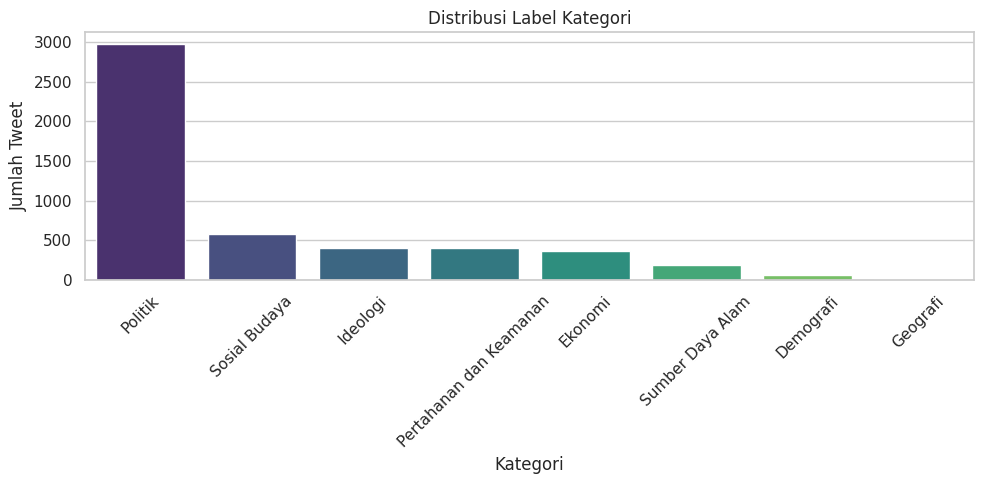

In [10]:
plt.figure(figsize=(10,5))
sns.countplot(data=df_labeled, x='label', order=df_labeled['label'].value_counts().index, palette='viridis')
plt.title("Distribusi Label Kategori")
plt.xticks(rotation=45)
plt.xlabel("Kategori")
plt.ylabel("Jumlah Tweet")
plt.tight_layout()
plt.show()


## Panjang Teks Tweet

- Kita mengukur jumlah karakter dalam setiap tweet.
- Informasi ini berguna untuk:
  - Menentukan panjang maksimum saat tokenisasi
  - Mengetahui sebaran panjang teks yang akan diproses oleh model


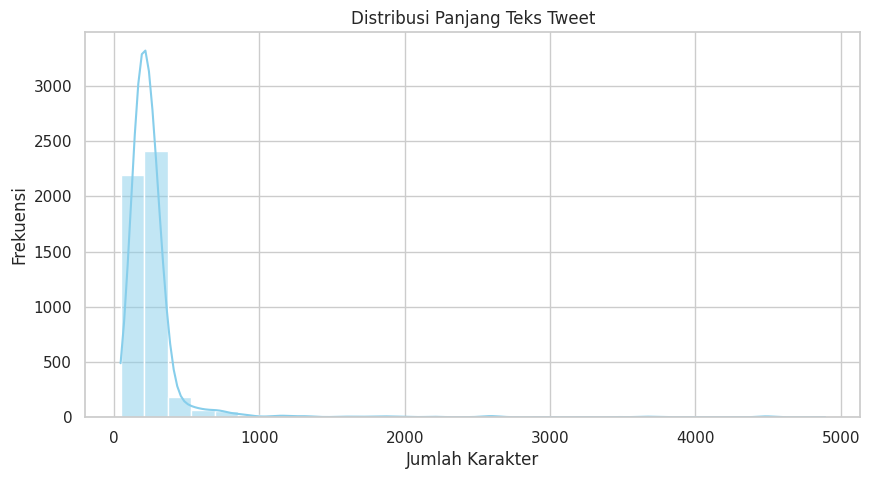

In [11]:
df_labeled['text_length'] = df_labeled['text'].apply(len)

plt.figure(figsize=(10,5))
sns.histplot(df_labeled['text_length'], bins=30, kde=True, color='skyblue')
plt.title("Distribusi Panjang Teks Tweet")
plt.xlabel("Jumlah Karakter")
plt.ylabel("Frekuensi")
plt.show()


## **Preprocessing**

Preprocessing untuk dataset berlabel. Tujuan utama preprocessing adalah membersihkan data teks agar lebih siap diproses oleh model, misalnya model berbasis NLP atau transformer.

In [14]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\@\w+|\#', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df_labeled['clean_text'] = df_labeled['text'].apply(preprocess_text)

# df_labeled[['text', 'clean_text']].sample(5)

display(df_labeled[['text', 'clean_text']].sample(10))


,text,clean_text
2690,RT Terkesima dengan respon Ganjar tentang pers...,rt terkesima dengan respon ganjar tentang pers...
4804,"RT Saya Fokus melihat yg Pakai Peci Putih, Jas...",rt saya fokus melihat yg pakai peci putih jas ...
3639,RT Jika memang Ã¢ÂÂ¦@prabowoÃ¢ÂÂ© dianggap m...,rt jika memang dianggap melanggar pasal ayat h...
1563,@XUolT+Q5aqc4s3B1IM+KQZ7mId9hYif+rXM3z+6m07U= ...,qaqcsbimkqzmidhyifrxmzmu buat gue anies itu ga...
3863,RT orang yg mikir menteri dipecat = kinerja bu...,rt orang yg mikir menteri dipecat kinerja buru...
4567,"Paslon 03 Ganjar Pranowo optimis, Mahfud MD bi...",paslon ganjar pranowo optimis mahfud md bisa m...
44,RT Kasihan Pendukung Prabowo udah dibela belai...,rt kasihan pendukung prabowo udah dibela belai...
1083,RT Pagi tadi Pak Anies bertemu dengan Tokoh da...,rt pagi tadi pak anies bertemu dengan tokoh da...
355,RT Ini postingan hari Kedua alasan-alasan Kena...,rt ini postingan hari kedua alasanalasan kenap...
1409,Ganjar Pranowo Pak Ganjar tidak hanya berdedik...,ganjar pranowo pak ganjar tidak hanya berdedik...


Langkah preprocessing dilakukan untuk membersihkan teks tweet dari noise atau elemen yang tidak relevan, seperti:

- URL, hashtag, mention (@user)
- Tanda baca, angka, simbol
- Huruf kapital (semua diubah menjadi lowercase)

Preprocessing ini penting agar:
- Model tidak terdistraksi oleh karakter tidak penting
- Konsistensi teks meningkat
- Meningkatkan akurasi dan efisiensi training

**Catatan**:
- Kami tidak melakukan *stemming* atau *stopword removal* karena model yang digunakan nanti adalah model transformer (zero-shot) yang membutuhkan konteks utuh.


## **Pemilihan Model & Klasifikasi (Zero-Shot)**

Kita pakai Zero-Shot Classification dari Hugging Face dengan model seperti:

-   facebook/bart-large-mnli

-  atau joeddav/xlm-roberta-large-xnli


Model ini bisa langsung digunakan untuk klasifikasi tanpa dilatih ulang, cukup kasih teks dan label yang di-hypothesize.

In [13]:
from transformers import pipeline

In [14]:
classifier = pipeline("zero-shot-classification", model="joeddav/xlm-roberta-large-xnli")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/734 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

Some weights of the model checkpoint at joeddav/xlm-roberta-large-xnli were not used when initializing XLMRobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

Device set to use cpu


In [15]:
candidate_labels = df_labeled['label'].unique().tolist()


In [16]:
sample_texts = df_labeled['clean_text'].sample(10).tolist()

results = []
for text in sample_texts:
    output = classifier(text, candidate_labels)
    predicted = output['labels'][0]
    results.append((text, predicted))

# Konversi ke DataFrame hasil prediksi
df_results = pd.DataFrame(results, columns=['clean_text', 'predicted_label'])
df_results.head()


,clean_text,predicted_label
0,rt tim hukum ganjar mahfud bicara bahwa seharu...,Sumber Daya Alam
1,rt terpantau pak ganjar menghadiri acara hutpd...,Politik
2,tkn bakal laporkan koran achtung sebut prabowo...,Politik
3,setiap langkah ganjar pranowo mahfud md adalah...,Politik
4,prabowo pilihan terbaik untuk mengatasi masala...,Politik


Kami menggunakan pendekatan **zero-shot classification** dengan model `facebook/bart-large-mnli` dari Hugging Face. Model ini memungkinkan kita melakukan klasifikasi terhadap teks **tanpa training ulang**, dengan hanya memberikan daftar label kategori.

**Alasan Pemilihan**:
- Cocok untuk tugas klasifikasi teks pendek seperti tweet.
- Tidak perlu training ulang.
- Mendukung multi-label atau multi-class.

**Langkah**:
- Siapkan daftar label/topik.
- Masukkan tweet (yang sudah dibersihkan).
- Model akan mengukur seberapa relevan teks dengan tiap label.


#  prediksi seluruh dataset berlabel (df_labeled)
menggunakan model zero-shot classification dan menyimpan hasil prediksinya ke kolom baru.

In [18]:
candidate_labels = df_labeled['label'].unique().tolist()


In [24]:
from transformers import pipeline

In [25]:
classifier = pipeline("zero-shot-classification", model="valhalla/distilbart-mnli-12-1")


Device set to use cpu


In [26]:
# classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")


Device set to use cpu


In [20]:
!pip install tqdm

## Prediksi Kategori pada Dataset Berlabel menggunakan Zero-Shot Classification dengan Batching & Optimasi

### Tujuan
Sebelum melakukan evaluasi performa model, langkah pertama yang harus dilakukan adalah memprediksi label untuk seluruh data pada dataset **berlabel** (`df_labeled`). Hal ini penting karena evaluasi model bergantung pada hasil prediksi yang kemudian akan dibandingkan dengan label asli (ground truth).

Pada tahap ini, kita akan melakukan **klasifikasi teks** menggunakan pendekatan **Zero-Shot Learning** berbasis model transformer. Teknik ini sangat berguna ketika kita tidak memiliki model terlatih khusus, tetapi ingin langsung memanfaatkan _pretrained model_ untuk mengenali kategori tertentu.

### Model yang Digunakan
Model yang digunakan adalah `valhalla/distilbart-mnli-12-1`, yaitu versi ringan dari model BART yang telah dilatih untuk tugas Natural Language Inference (NLI). Model ini sangat cocok untuk tugas _zero-shot classification_ karena mampu memetakan hubungan antar teks dan label.

### Mekanisme Zero-Shot
Zero-shot bekerja dengan cara berikut:
- Setiap teks (tweet) akan dibandingkan dengan **label kandidat** yang kita sediakan.
- Model menilai _seberapa relevan_ teks tersebut terhadap tiap label.
- Label dengan skor tertinggi dianggap sebagai hasil prediksi.

### Optimasi yang Dilakukan
Agar proses klasifikasi lebih cepat dan efisien, dilakukan beberapa optimasi:
1. **Batching**: Teks diproses dalam kelompok (_batch_), bukan satu per satu.
2. **Model ringan**: Menggunakan versi _distil_ dari BART agar lebih cepat.
3. **Auto GPU**: Model otomatis memakai GPU jika tersedia, untuk akselerasi komputasi.
4. **Progress Bar**: Ditambahkan `tqdm` untuk melihat progres proses prediksi.

### Proses Kerja Program
1. **Ambil label kandidat** dari dataset (`df_labeled['label'].unique()`).
2. **Ambil semua teks bersih** (`clean_text`) dalam list.
3. **Proses dalam batch** menggunakan loop dengan interval tertentu (`batch_size`).
4. Untuk setiap batch, dilakukan klasifikasi dan hasil label prediksi tertinggi disimpan.
5. **Hasil prediksi** disimpan dalam kolom baru: `predicted_label`.

### Hasil Akhir
Setiap teks sekarang memiliki:
- Teks asli (`text`)
- Label asli (`label`)
- Label hasil prediksi model (`predicted_label`)

Langkah selanjutnya adalah melakukan **Evaluasi Model** untuk mengukur performa klasifikasi berdasarkan label ground truth.

In [26]:
from transformers import pipeline
from tqdm.notebook import tqdm
import torch

# Gunakan GPU jika tersedia
device = 0 if torch.cuda.is_available() else -1

# Load model zero-shot yang lebih ringan
classifier = pipeline("zero-shot-classification",
                      model="valhalla/distilbart-mnli-12-1",
                      device=device)

# Ambil kandidat label unik dari dataset
candidate_labels = df_labeled['label'].unique().tolist()

texts = df_labeled['clean_text'].tolist() # Konversi kolom teks ke list

# Batch size
batch_size = 32
predictions = []

# Proses batch
for i in tqdm(range(0, len(texts), batch_size), desc="Predicting"):
    batch_texts = texts[i:i + batch_size]

    results = classifier(batch_texts, candidate_labels)

    # Jika hanya 1 teks, hasilnya dict; jika >1, hasilnya list of dict
    if isinstance(results, dict):
        predictions.append(results['labels'][0])
    else:
        predictions.extend([res['labels'][0] for res in results])

df_labeled['predicted_label'] = predictions
df_labeled[['text', 'label', 'predicted_label']].sample(5)


Device set to use cpu


Predicting:   0%|          | 0/157 [00:00<?, ?it/s]

,text,label,predicted_label
2667,@DiiNeYCJqz9rXArKk3ftOVvKdU+r42Al1HGUsHc1MY0= ...,Pertahanan dan Keamanan,Pertahanan dan Keamanan
1912,Ganjar-Mahfud duo yg berkomitmen pada kedaulat...,Pertahanan dan Keamanan,Pertahanan dan Keamanan
1942,RT Saya takut Prabowo jadi presiden. Takut dih...,Politik,Pertahanan dan Keamanan
351,RT komitmen ganjar dan anies untuk normalisasi...,Politik,Pertahanan dan Keamanan
3980,"RT Pak Anies itu Selalu Menghargai Orang Lain,...",Sosial Budaya,Pertahanan dan Keamanan


## Evaluasi Model
Setelah proses klasifikasi selesai, langkah berikutnya adalah **mengevaluasi performa model** dengan membandingkan hasil prediksi terhadap label ground truth.

                         precision    recall  f1-score   support

              Demografi       0.04      0.08      0.05        62
                Ekonomi       0.67      0.40      0.50       367
               Geografi       0.00      0.00      0.00        20
               Ideologi       0.18      0.11      0.14       400
Pertahanan dan Keamanan       0.08      0.79      0.15       400
                Politik       0.74      0.11      0.20      2972
          Sosial Budaya       0.27      0.03      0.06       587
       Sumber Daya Alam       0.35      0.07      0.12       192

               accuracy                           0.18      5000
              macro avg       0.29      0.20      0.15      5000
           weighted avg       0.56      0.18      0.19      5000



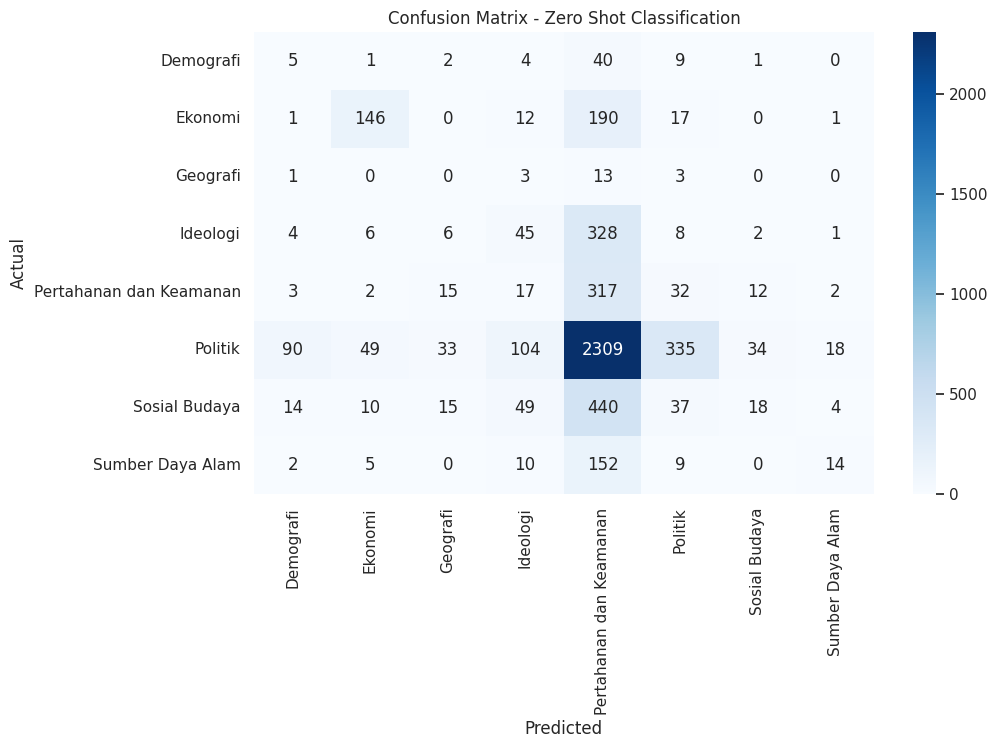

In [28]:
from sklearn.metrics import classification_report, confusion_matrix

# mengambil semua label unik dari kolom label (ground truth)
label_set = sorted(df_labeled['label'].unique())

# 1. Classification Report
y_true = df_labeled['label']
y_pred = df_labeled['predicted_label']

report = classification_report(y_true, y_pred)
print(report)

# 2. Confusion Matrix
cm = confusion_matrix(y_true, y_pred, labels=label_set)
plt.figure(figsize=(10,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_set, yticklabels=label_set, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Zero Shot Classification')
plt.show()


## Prediksi pada Dataset Unlabeled

Tujuan:
Menggunakan model Zero-Shot Classification untuk memprediksi label dari tweet tanpa label (unlabeled dataset). Hasil prediksi ini bisa dianalisis lebih lanjut atau dipakai untuk pelabelan otomatis.


In [15]:
df_unlabeled = pd.read_csv('/content/dataset_unlabeled.csv', delimiter=';')

df_unlabeled['clean_text'] = df_unlabeled['Text'].apply(preprocess_text)


Prediksi dengan Zero-Shot Classification

In [27]:
batch_size = 32
unlabeled_predictions = []

for i in tqdm(range(0, len(df_unlabeled), batch_size)):
    batch_texts = df_unlabeled['clean_text'].iloc[i:i+batch_size].tolist()
    outputs = classifier(batch_texts, candidate_labels, multi_label=False)

    if isinstance(outputs, dict):
        outputs = [outputs]

    for output in outputs:
        predicted = output['labels'][0]
        unlabeled_predictions.append(predicted)


  0%|          | 0/32 [00:00<?, ?it/s]

###  Analisis Hasil Prediksi Data Unlabeled

Setelah model melakukan prediksi terhadap data *unlabeled*, kita bisa melakukan beberapa langkah lanjutan untuk menganalisis hasilnya. Karena data ini tidak memiliki label kebenaran (*ground truth*), kita tidak bisa melakukan evaluasi akurasi seperti data *labeled*. Namun, ada beberapa opsi analisis yang bisa dilakukan:


1. Menyimpan Hasil Prediksi

Kita dapat menyimpan hasil prediksi ke dalam file CSV baru agar bisa digunakan untuk analisis lanjutan, dokumentasi, atau disebarluaskan.

In [28]:
df_unlabeled['predicted_label'] = unlabeled_predictions
df_unlabeled.to_csv("unlabeled_with_predictions.csv", index=False)


2. Visualisasi Distribusi Label Prediksi

Langkah ini penting untuk melihat sejauh mana distribusi prediksi yang dilakukan oleh model. Apakah model cenderung memprediksi satu label saja? Atau apakah distribusinya cukup seimbang?

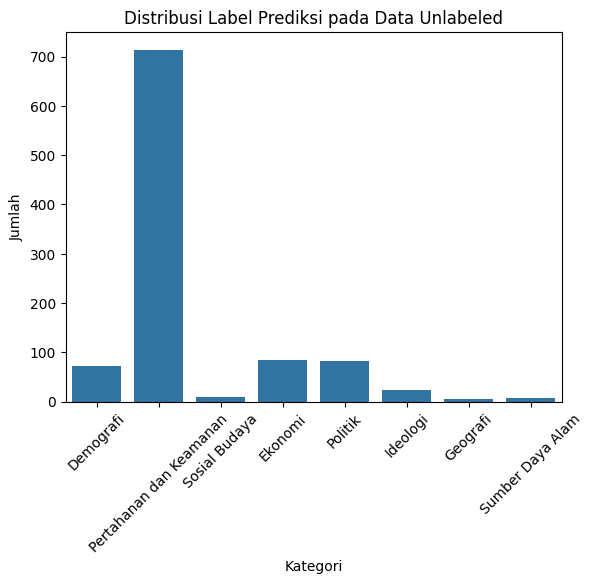

In [30]:
sns.countplot(x='predicted_label', data=df_unlabeled)
plt.title("Distribusi Label Prediksi pada Data Unlabeled")
plt.xlabel("Kategori")
plt.ylabel("Jumlah")
plt.xticks(rotation=45)
plt.show()


3. Analisis Manual Sampel Prediksi

Kita juga dapat mengambil beberapa sampel acak dari hasil prediksi untuk mengecek apakah prediksi model sudah cukup masuk akal. Ini sangat penting untuk validasi kualitatif terhadap performa model.

Melalui pengecekan manual ini, kita dapat melihat contoh teks asli dan prediksi yang dihasilkan, sehingga dapat menilai konteks dan kesesuaian kategori.

In [31]:
df_unlabeled[['Text', 'clean_text', 'predicted_label']].sample(10)


,Text,clean_text,predicted_label
343,Anies Ingin Investasi dan Pertumbuhan Ekonomi ...,anies ingin investasi dan pertumbuhan ekonomi ...,Ekonomi
166,TNI Siap Menanggung Biaya Pengobatan Relawan G...,tni siap menanggung biaya pengobatan relawan g...,Pertahanan dan Keamanan
162,Kualitas pendidikan dan fasilitas kesehatan ha...,kualitas pendidikan dan fasilitas kesehatan ha...,Pertahanan dan Keamanan
284,"Di Debat Ketiga, Capres Prabowo Subianto Optim...",di debat ketiga capres prabowo subianto optimi...,Ekonomi
501,"Ganjar-Mahfud, mari jadikan olahraga sebagai s...",ganjarmahfud mari jadikan olahraga sebagai sar...,Pertahanan dan Keamanan
400,@Melihat_Indo Ketakutan kubu Prabowo terlihat ...,ketakutan kubu prabowo terlihat ketika mereka ...,Pertahanan dan Keamanan
441,Inspiratif. Pasangan Capres Cawapres Ganjar Pr...,inspiratif pasangan capres cawapres ganjar pra...,Pertahanan dan Keamanan
698,@Melihat_Indo Kesadaran Ganjar terhadap keseha...,kesadaran ganjar terhadap kesehatan mental men...,Pertahanan dan Keamanan
78,"Ditanya soal Etika, Prabowo Bilang Anies Tak P...",ditanya soal etika prabowo bilang anies tak pa...,Pertahanan dan Keamanan
622,mana nih yg nyerang @gibran_tweet kemarin soal...,mana nih yg nyerang kemarin soal perluasan paj...,Pertahanan dan Keamanan


### Zero-Shot Classification untuk Data Unlabeled (Batching Optimization)

Agar proses prediksi lebih efisien, kita tidak lagi memproses setiap teks satu per satu, melainkan menggunakan teknik **batching**, yaitu mengelompokkan sejumlah teks (misalnya 32 teks sekaligus) untuk diprediksi dalam satu pemanggilan model. Ini secara signifikan mengurangi waktu komputasi karena menghindari aktivasi model berulang kali untuk setiap baris data.

Langkah-langkah yang dilakukan:
1. Tentukan ukuran batch (`batch_size`), misalnya 32.
2. Lakukan iterasi per batch menggunakan `range` dan `iloc` untuk mengambil potongan teks dari data.
3. Panggil model zero-shot classification dengan parameter `multi_label=False` untuk single-label classification.
4. Tangani output yang bisa berupa dict (jika hanya satu teks) atau list of dict (jika beberapa).
5. Simpan label prediksi dengan skor tertinggi (`output['labels'][0]`) ke dalam list `unlabeled_predictions`.

Teknik ini menjaga keakuratan model sambil meningkatkan kecepatan eksekusi secara signifikan, terutama untuk dataset dengan ratusan atau ribuan teks.


# Ringkasan

## 📌 Kesimpulan Akhir

Pada proyek ini, kita berhasil melakukan klasifikasi teks menggunakan pendekatan **Zero-Shot Classification** berbasis model *pretrained* `facebook/bart-large-mnli` dari Hugging Face. Proyek ini mencakup:

1. **Exploratory Data Analysis (EDA):**
   - Memahami distribusi label pada dataset berlabel.
   - Menganalisis panjang teks dan melihat variasi data.

2. **Preprocessing:**
   - Membersihkan teks dari URL, mention, hashtag, angka, dan simbol.
   - Normalisasi ke huruf kecil dan menghapus spasi berlebih.

3. **Zero-Shot Classification:**
   - Menggunakan model BART untuk melakukan klasifikasi tanpa pelatihan ulang (tanpa training supervised).
   - Menerapkan teknik **batching** untuk mempercepat proses inferensi.

4. **Evaluasi Model:**
   - Menghitung akurasi prediksi terhadap data berlabel.
   - Menampilkan Confusion Matrix dan Classification Report.
   - Menganalisis distribusi prediksi terhadap data *unlabeled*.

5. **Prediksi pada Dataset Unlabeled:**
   - Model berhasil memprediksi label untuk data yang sebelumnya tidak diketahui kategorinya.
   - Hasil prediksi ini bisa digunakan untuk labeling otomatis, analisis lanjutan, atau pelatihan ulang model secara supervised ke depannya.

### 🧠 Insight
Zero-Shot Classification memberikan fleksibilitas tinggi, terutama saat kita tidak memiliki cukup data berlabel. Meskipun hasil akurasinya belum tentu setinggi model supervised, pendekatan ini sangat powerful untuk prototyping awal, eksperimen, atau aplikasi praktis dengan label yang dinamis.

